<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/2025-1/notebooks/1d_procesamiento_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción al pre-procesamiento de datos para AP (Audio)

---
Curso: Aprendizaje Profundo.

Profesor: Gibran Fuentes Pineda.

Ayudantes: Fernando Nava y Rodrigo del Moral

---

En esta libreta nos familiarizaremos en como crear y manipular formas de onda y espectogramas como representaciones para modelos de aprendizaje profundo.

## 0. Introducción

<img src="https://www.digitalengineering247.com/images/wide/MathWorks_1500.jpg"/>

Imagen tomada de https://www.digitalengineering247.com/article/deep-learning-and-design-engineering



## 1. Preparación

In [ ]:
# Colab
! pip install torchinfo
try:
    import torchaudio
except:
    ! pip install torchaudio

### 1.1 Bibliotecas

In [ ]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# audio
import librosa
import librosa.display
import IPython as ip


# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# redes audio
import torchaudio
import torchaudio.transforms as T
# redes visión
import torchvision.models as tvm

# redes neuronales
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS
# inspección de arquitectura
from torchinfo import summary

# barras de progreso
from tqdm.auto import trange

#Counter
import collections

# Files
from os.path import join


In [ ]:
#print(torch.__version__)
print(torchaudio.__version__)
print(librosa.__version__)

2.0.2+cu118
0.10.1


### 1.2. Auxiliares

In [ ]:
#Creamos carpeta en colab para los datos:
! mkdir datos

In [ ]:
! ls

datos  sample_data


In [ ]:
# directorio de datos
DATA_DIR = 'datos'

## 2. Datos

In [ ]:
# Se utiliza el conjunto de datos SPEECHCOMMANDS:
# https://pytorch.org/audio/stable/generated/torchaudio.datasets.SPEECHCOMMANDS.html#torchaudio.datasets.SPEECHCOMMANDS
ds = SPEECHCOMMANDS(DATA_DIR, download=True)

100%|██████████| 2.26G/2.26G [00:18<00:00, 134MB/s]


In [ ]:
len(ds)

105829

In [ ]:
! ls -R {DATA_DIR} | head -55


datos:
SpeechCommands
speech_commands_v0.02.tar.gz

datos/SpeechCommands:
speech_commands_v0.02

datos/SpeechCommands/speech_commands_v0.02:
_background_noise_
backward
bed
bird
cat
dog
down
eight
five
follow
forward
four
go
happy
house
learn
left
LICENSE
marvin
nine
no
off
on
one
README.md
right
seven
sheila
six
stop
testing_list.txt
three
tree
two
up
validation_list.txt
visual
wow
yes
zero

datos/SpeechCommands/speech_commands_v0.02/_background_noise_:
doing_the_dishes.wav
dude_miaowing.wav
exercise_bike.wav
pink_noise.wav
README.md


## 3. Exploración

### 3.1 Examinar un ejemplo

In [ ]:
waveform, sample_rate, label, id_spk, utt = ds[3078]

print(
    f'Etiqueta: {label}\n'
    f'Forma de onda: {waveform.shape}\n'
    f'Frecuencia de muestreo: {sample_rate}\n'
    f'Duración: {waveform.shape[1] / sample_rate}\n'
    f'Tipo: {waveform.dtype}\n'
)

Etiqueta: bed
Forma de onda: torch.Size([1, 14861])
Frecuencia de muestreo: 16000
Duración: 0.9288125
Tipo: torch.float32



In [ ]:
waveform

tensor([[ 0.0002,  0.0004,  0.0002,  ..., -0.0002, -0.0003, -0.0003]])

### 3.2 Duración del conjunto

In [ ]:
durations = []
for i in trange(len(ds)):
    waveform, sample_rate, label ,id_spk, utt = ds[i]
    num_channels, samples = waveform.shape
    durations.append(samples)

  0%|          | 0/105829 [00:00<?, ?it/s]

Duraciones
Counter({16000: 95394, 14336: 696, 15702: 649, 15604: 575, 15019: 575, 14861: 551, 14118: 503, 12288: 490, 13375: 455, 13654: 415, 12971: 381, 12056: 370, 10240: 295, 12632: 247, 13653: 239, 12970: 237, 11606: 235, 11605: 210, 15018: 208, 11889: 200, 15701: 198, 10922: 195, 10923: 170, 9557: 156, 11146: 144, 8192: 138, 8874: 136, 11888: 135, 12631: 127, 12136: 121, 11145: 107, 10402: 99, 12052: 86, 9558: 80, 10403: 77, 9659: 76, 8875: 69, 7509: 67, 9660: 57, 6826: 48, 8916: 45, 12132: 41, 6144: 33, 8173: 32, 8917: 31, 7430: 22, 15360: 18, 6687: 15, 8174: 15, 11976: 15, 12456: 13, 13995: 12, 13312: 12, 11947: 11, 5461: 11, 15531: 10, 7431: 10, 14678: 10, 12630: 9, 12212: 9, 12376: 9, 12800: 8, 9216: 7, 15872: 7, 14507: 7, 11776: 7, 14848: 7, 5201: 6, 13142: 6, 9899: 6, 12459: 6, 13141: 6, 12216: 6, 13483: 5, 11264: 5, 7510: 5, 12118: 5, 12536: 5, 5944: 5, 14677: 5, 6827: 5, 10581: 4, 12629: 4, 9046: 4, 4778: 4, 9387: 4, 15190: 4, 7168: 3, 15189: 3, 14490: 3, 7851: 3, 14166: 3

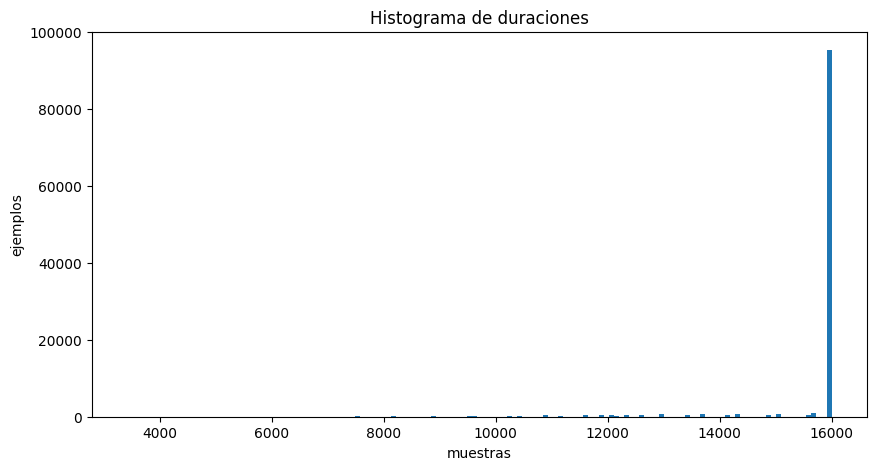

In [ ]:
counter = collections.Counter(durations)

print('Duraciones')
print(counter)

plt.figure(figsize=(10, 5))
plt.hist(durations, bins=len(counter.keys())+1)
plt.bar(counter.keys(), counter.values())
plt.title('Histograma de duraciones')
plt.xlabel('muestras')
plt.ylabel('ejemplos')
plt.show()

In [ ]:
# número mínimo de muestras
min_samples = min(counter.keys())
print(f"min samples: {min_samples}")
max_samples = max(counter.keys())
print(f"max samples: {max_samples}")

min samples: 3413
max samples: 16000


## 4. Formas de onda

### 4.1 Audio

In [ ]:
# leemos el primer ejemplo
waveformA, sample_rateA, labelA, id_spkA, uttA = ds[1]

# comvertimos a numpy para ipython y librosa
waveformA_numpy = waveformA.flatten().numpy()

print(
    f'Etiqueta: {labelA}\n'
    f'Forma de onda (forma torch): {waveformA.shape}\n'
    f'Forma de onda (forma numpy): {waveformA_numpy.shape}\n'
    f'Frecuencia de muestreo: {sample_rateA}\n'
    f'Duración: {waveformA_numpy.shape[0] / sample_rateA}\n'
    f'Tipo: {waveformA.dtype}'
)

Etiqueta: backward
Forma de onda (forma torch): torch.Size([1, 16000])
Forma de onda (forma numpy): (16000,)
Frecuencia de muestreo: 16000
Duración: 1.0
Tipo: torch.float32


In [ ]:
# reproducimos
ip.display.Audio(waveformA_numpy, rate=sample_rateA)

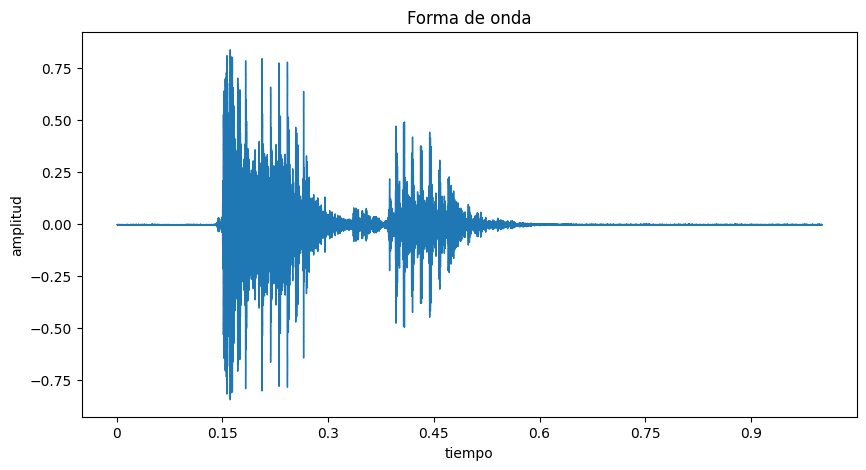

In [ ]:
# graficamos la forma de onda
plt.figure(figsize=(10, 5))
librosa.display.waveshow(waveformA_numpy, sr=sample_rateA)
plt.title('Forma de onda')
plt.xlabel('tiempo')
plt.ylabel('amplitud')
plt.show()

In [ ]:
# leemos el primer ejemplo
waveformB, sample_rateB, labelB, id_spkB, uttB = ds[3078]

# comvertimos a numpy para ipython y librosa
waveformB_numpy = waveformB.flatten().numpy()

print(
    f'Etiqueta: {labelB}\n'
    f'Forma de onda (forma torch): {waveformB.shape}\n'
    f'Forma de onda (forma numpy): {waveformB_numpy.shape}\n'
    f'Frecuencia de muestreo: {sample_rateB}\n'
    f'Duración: {waveformB_numpy.shape[0] / sample_rateB}\n'
    f'Tipo: {waveformB.dtype}'
)

Etiqueta: bed
Forma de onda (forma torch): torch.Size([1, 14861])
Forma de onda (forma numpy): (14861,)
Frecuencia de muestreo: 16000
Duración: 0.9288125
Tipo: torch.float32


In [ ]:
# reproducimos
ip.display.Audio(waveformB_numpy, rate=sample_rateB)

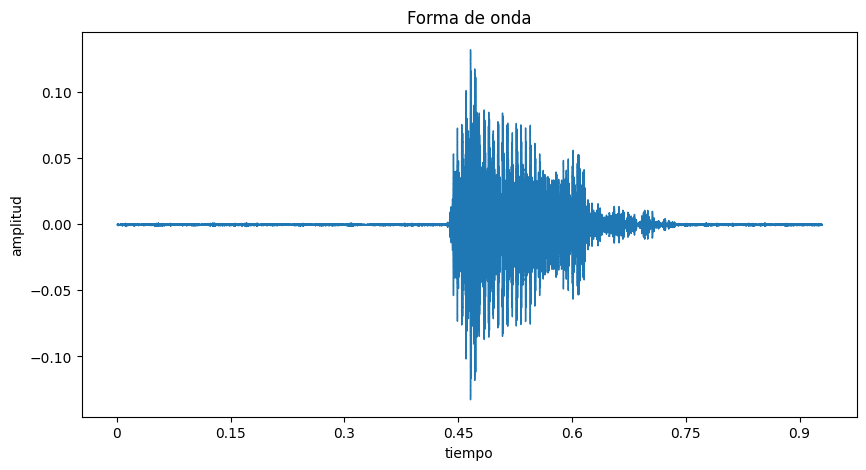

In [ ]:
# graficamos la forma de onda
plt.figure(figsize=(10, 5))
librosa.display.waveshow(waveformB_numpy, sr=sample_rateB)
plt.title('Forma de onda')
plt.xlabel('tiempo')
plt.ylabel('amplitud')
plt.show()

## 5. Características


<img src="https://www.mathworks.com/help/dsp/ref/stft_output.png"/>

Imagen tomada de https://www.mathworks.com/help/dsp/ref/dsp.stft.html

El valor de n_fft determina la resolución del eje de frecuencia.

hop_length determina la resolución del eje de tiempo. De forma predeterminada se utiliza el valor de n_fft // 4.

In [ ]:
# tamaño de la ventana
n_fft = 1000
# tamaño del salto
hop_length = n_fft // 2

### 5.1 Espectrogramas

Para obtener la composición de frecuencia de una señal de audio que varía con el tiempo, puede usar torchaudio.transforms.Spectrogram().

Los humanos perciben la frecuencia de forma logarítmica.

In [ ]:
spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)(waveformA)
print(spectrogram.shape, spectrogram.dtype)
spectrogram

torch.Size([1, 501, 33]) torch.float32


tensor([[[3.4630e-04, 2.9274e-05, 2.8580e-05,  ..., 1.0255e-05,
          1.8649e-05, 6.4235e-05],
         [3.4962e-04, 1.0071e-04, 2.9823e-05,  ..., 1.0178e-04,
          3.6574e-05, 1.6169e-04],
         [6.3828e-04, 1.0124e-04, 6.4328e-06,  ..., 4.3791e-04,
          1.5712e-04, 2.7300e-04],
         ...,
         [6.7521e-08, 1.2022e-07, 2.1205e-07,  ..., 9.6493e-07,
          1.1402e-06, 8.1128e-09],
         [9.5221e-08, 1.6604e-07, 1.5564e-07,  ..., 1.7882e-06,
          1.2326e-06, 2.1697e-07],
         [3.6251e-08, 8.1307e-08, 3.7848e-07,  ..., 9.6889e-07,
          1.1262e-06, 4.3512e-07]]])

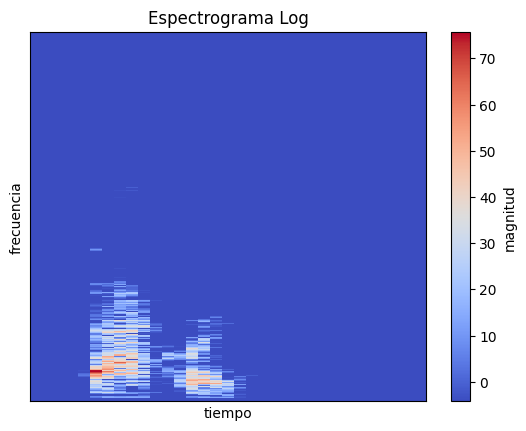

In [ ]:
spectrogram_numpy = spectrogram.squeeze().numpy()
log_spectrogram = librosa.amplitude_to_db(spectrogram_numpy)

librosa.display.specshow(log_spectrogram,
                         sr=sample_rateA, hop_length=hop_length)
plt.title('Espectrograma Log')
plt.xlabel('tiempo')
plt.ylabel('frecuencia')
# Se muestra la barra de color para darnos una idea del rango de amplitudes en decibeles.
cbar = plt.colorbar()
cbar.set_label('magnitud', rotation=90)
plt.show()

### 5.2 Espectograma Log-Mel

Frecuencias a Escala de Mel

$m = 2595*log(1+\frac{f}{500})$

https://www.youtube.com/watch?v=9GHCiiDLHQ4


<img src="http://turing.iimas.unam.mx/~ivanvladimir/images/mfcc_fig5.png"/>

https://turing.iimas.unam.mx/~ivanvladimir/posts/mfcc/

In [ ]:
mel_spectrogram = T.MelSpectrogram(n_fft=n_fft, hop_length=hop_length)(waveformA)
print(mel_spectrogram.shape, mel_spectrogram.dtype)
mel_spectrogram

torch.Size([1, 128, 33]) torch.float32


tensor([[[2.9521e-04, 8.5035e-05, 2.5183e-05,  ..., 8.5944e-05,
          3.0883e-05, 1.3653e-04],
         [5.1000e-04, 8.7933e-05, 9.2324e-06,  ..., 3.2841e-04,
          1.1784e-04, 2.2002e-04],
         [5.3278e-04, 3.4490e-05, 1.0678e-04,  ..., 1.9573e-04,
          1.2886e-04, 2.4424e-04],
         ...,
         [6.7079e-05, 7.0378e-05, 4.9343e-05,  ..., 6.4436e-05,
          5.0066e-05, 6.8437e-05],
         [2.4897e-05, 2.3971e-05, 3.0510e-05,  ..., 4.6032e-05,
          1.7484e-05, 2.6811e-05],
         [1.6118e-05, 7.5180e-06, 5.1918e-06,  ..., 1.5016e-05,
          1.1879e-05, 2.0226e-05]]])

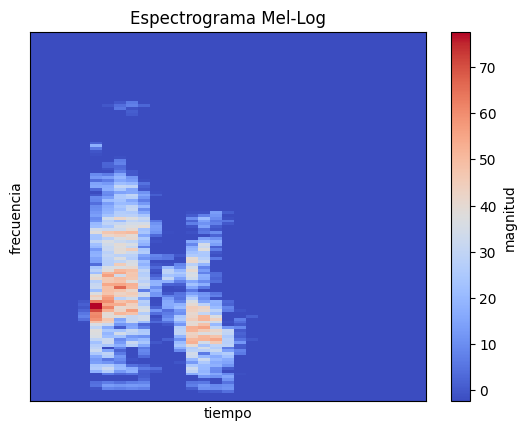

In [ ]:
mel_spectrogram_numpy = mel_spectrogram.squeeze().numpy()
log_mel_spectrogram_numpy = librosa.amplitude_to_db(mel_spectrogram_numpy)

librosa.display.specshow(log_mel_spectrogram_numpy,
                         sr=sample_rateA, hop_length=hop_length)
plt.title('Espectrograma Mel-Log')
plt.xlabel('tiempo')
plt.ylabel('frecuencia')
cbar = plt.colorbar()
cbar.set_label('magnitud', rotation=90)
plt.show()

### 5.3 MFCCs (Mel-frequency cepstral coeficients)

1.- Separar la señal en pequeños tramos.

2.- A cada tramo aplicarle la Transformada de Fourier discreta y obtener la potencia espectral de la señal.

3.- Aplicar el banco de filtros correspondientes a la Escala Mel al espectro obtenido en el paso anterior y sumar las energías en cada uno de ellos.

4.- Tomar el logaritmo de todas las energías de cada frecuencia mel

5.-Aplicarle la transformada de coseno discreta a estos logaritmos.

https://turing.iimas.unam.mx/~ivanvladimir/posts/mfcc/

In [ ]:
mfccs = T.MFCC()(waveformA)
print(mfccs.shape, mfccs.dtype)
mfccs

torch.Size([1, 40, 81]) torch.float32


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


tensor([[[-5.1596e+02, -5.2068e+02, -5.1357e+02,  ..., -4.9976e+02,
          -5.0227e+02, -5.0542e+02],
         [ 1.9111e+01,  1.3181e+01,  1.9767e+01,  ...,  2.2714e+01,
           2.5238e+01,  1.9226e+01],
         [ 1.3228e+01,  9.5514e+00,  1.3591e+01,  ...,  1.8591e+01,
           1.4602e+01,  2.0137e+01],
         ...,
         [ 3.5582e+00,  3.1715e+00,  2.6139e+00,  ..., -2.3913e+00,
           2.5416e+00, -3.9608e+00],
         [ 9.7919e-01,  1.7033e+00, -2.4974e-01,  ..., -3.5801e+00,
           5.0414e-01, -4.9371e+00],
         [-5.3154e-01,  1.4709e+00,  3.0775e-01,  ...,  1.9141e-01,
           4.2464e+00, -5.0865e+00]]])

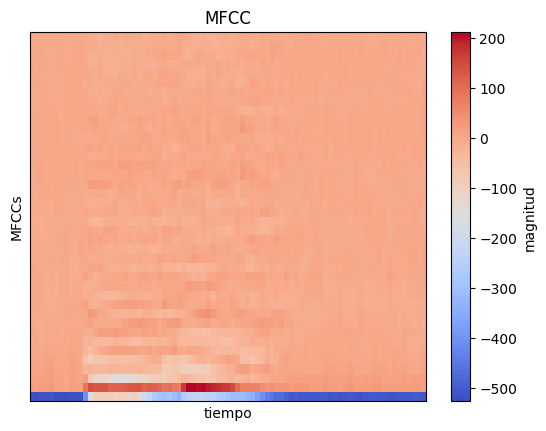

In [ ]:
mfccs_numpy = mfccs.squeeze().numpy()

librosa.display.specshow(mfccs_numpy, sr=sample_rateA, hop_length=hop_length)
plt.title('MFCC')
plt.xlabel('tiempo')
plt.ylabel('MFCCs')
cbar = plt.colorbar()
cbar.set_label('magnitud', rotation=90)
plt.show()

## 6. Conjunto de Datos (Dataset)

In [ ]:
# tamaño del lote
BATCH_SIZE = 32

# parámetros de audio
SECS = 1
SAMPLE_RATE = 16000

# parámetros FFT
N_FFT = 400
HOP_LENGTH = N_FFT // 2

# SpeechCommands classes
CLASSES = (
    'backward', 'bed', 'bird', 'cat', 'dog',
    'down', 'eight', 'five', 'follow', 'forward',
    'four', 'go', 'happy', 'house', 'learn',
    'left', 'marvin', 'nine', 'no', 'off',
    'on', 'one', 'right', 'seven', 'sheila',
    'six', 'stop', 'three', 'tree', 'two',
    'up', 'visual', 'wow', 'yes', 'zero'
)

NUM_CLASSES = len(CLASSES)
CLASS_IDX = {c: i for i, c in enumerate(CLASSES)}
print(CLASS_IDX)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


# reproducibilidad
set_seed()

{'backward': 0, 'bed': 1, 'bird': 2, 'cat': 3, 'dog': 4, 'down': 5, 'eight': 6, 'five': 7, 'follow': 8, 'forward': 9, 'four': 10, 'go': 11, 'happy': 12, 'house': 13, 'learn': 14, 'left': 15, 'marvin': 16, 'nine': 17, 'no': 18, 'off': 19, 'on': 20, 'one': 21, 'right': 22, 'seven': 23, 'sheila': 24, 'six': 25, 'stop': 26, 'three': 27, 'tree': 28, 'two': 29, 'up': 30, 'visual': 31, 'wow': 32, 'yes': 33, 'zero': 34}


In [ ]:
def identity(x):
    return x


def label2index(label):
    return CLASS_IDX[label]


class SPEECHCOMMANDS2(SPEECHCOMMANDS):

    def __init__(self, root, download=False, subset=None,
                 waveform_tsfm=identity, label_tsfm=identity):
        super().__init__(root=root, download=download, subset=subset)
        self.waveform_tsfm = waveform_tsfm
        self.label_tsfm = label_tsfm

    def __getitem__(self, i):
        waveform, sample_rate, label, *_ = super().__getitem__(i)
        x = self.waveform_tsfm(waveform)
        y = self.label_tsfm(label)
        return x, y, label, sample_rate

### 6.1 Transformación para la forma de onda

In [ ]:
class WaveformPadTruncate(nn.Module):

    def __init__(self, secs=SECS, sample_rate=SAMPLE_RATE):
        super().__init__()
        self.samples = secs * sample_rate

    def forward(self, waveform):
        samples = waveform.shape[1]

        if samples < self.samples:
            difference = self.samples - samples
            padding = torch.zeros(1, difference)
            waveform = torch.cat([waveform, padding], 1)

        elif samples > self.samples:
            start = random.randint(0, waveform.shape[1] - self.samples)
            # Devuelve un nuevo tensor que es una versión reducida del tensor de entrada.
            waveform = waveform.narrow(1, start, self.samples) # (dimension, start, length)

        return waveform

        #start = random.randint(0, waveform.shape[1] - self.samples)
        #waveform = waveform.narrow(1, start, self.samples)
        #return waveform

### 6.2 Dataset y Dataloader

In [ ]:
# creamos un Dataset
ds = SPEECHCOMMANDS2(
    # directorio de datos
    root=DATA_DIR,
    # transformación de la forma de onda
    waveform_tsfm=WaveformPadTruncate(),
    # transformación de etiqueta
    label_tsfm=label2index,
)

# creamos un DataLoader
dl = DataLoader(
    # conjunto
    ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True)


### 6.3. Inspección del conjunto

In [ ]:
# desplegamos un lote de ejemplos
x, y, labels, sr = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([32, 1, 16000]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


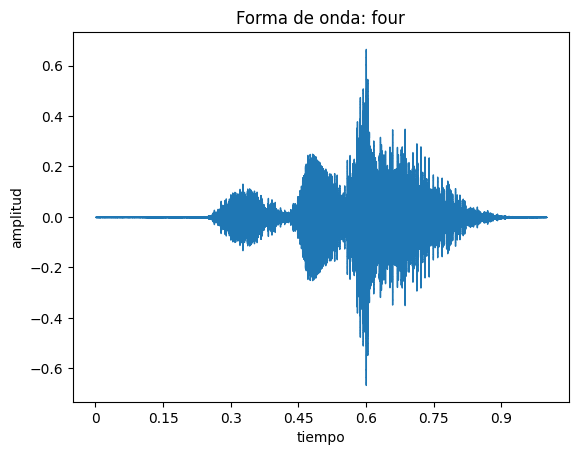

In [ ]:
# inspeccionemos un ejemplo
waveform = x[0].squeeze().numpy()
label = labels[0]

# grafiquemos forma de onda
librosa.display.waveshow(waveform, sr=SAMPLE_RATE)
plt.title(f'Forma de onda: {label}')
plt.xlabel('tiempo')
plt.ylabel('amplitud')
plt.show()

# reproductor
ip.display.Audio(waveform, rate=SAMPLE_RATE)

In [ ]:
# leemos un ejemplo
waveformB, sample_rateB, labelB, id_spkB = ds[3078]

# comvertimos a numpy para ipython y librosa
waveformB_numpy = waveformB.flatten().numpy()

print(
    f'Etiqueta: {labelB}\n'
    f'Forma de onda (forma torch): {waveformB.shape}\n'
    f'Forma de onda (forma numpy): {waveformB_numpy.shape}\n'
    f'Frecuencia de muestreo: {sample_rateB}\n'
    f'Duración: {waveformB_numpy.shape[0] / sample_rateB}\n'
    f'Tipo: {waveformB.dtype}'
)

Etiqueta: bed
Forma de onda (forma torch): torch.Size([1, 16000])
Forma de onda (forma numpy): (16000,)
Frecuencia de muestreo: 1
Duración: 16000.0
Tipo: torch.float32


# Audio Data Augmentation
https://pytorch.org/audio/main/tutorials/audio_data_augmentation_tutorial.html

### Aplicar efectos y filtrar

Efectos y filtros:
https://sox.sourceforge.net/sox.html



In [ ]:
# Define effects
effects = [
    ["channels", "1"],
    ["lowpass", "-1", "300"],  # aplicar filtro de paso bajo unipolar
    ["speed", "0.8"],  # reducir velocidad
    # Esto sólo cambia la frecuencia de muestreo, por lo que es necesario
    # agregar el efecto "rate" con la frecuencia de muestreo original después de esto.
    ["rate", f"{SAMPLE_RATE}"]
]

In [ ]:
# Apply effects
waveform2, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(x[0], SAMPLE_RATE, effects)

print(x[0].shape, SAMPLE_RATE)
print(waveform2.shape, sample_rate2)

torch.Size([1, 16000]) 16000
torch.Size([1, 20000]) 16000


(20000,)


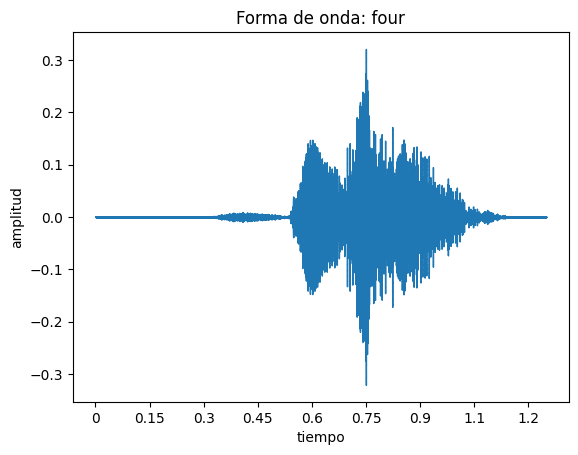

In [ ]:
# inspeccionemos un ejemplo
waveform2 = waveform2.squeeze().numpy()
print(waveform2.shape)
label2 = labels[0]

# grafiquemos forma de onda
librosa.display.waveshow(waveform2, sr=SAMPLE_RATE)
plt.title(f'Forma de onda: {label2}')
plt.xlabel('tiempo')
plt.ylabel('amplitud')
plt.show()

# reproductor
ip.display.Audio(waveform2, rate=SAMPLE_RATE)

In [ ]:
class SPEECHCOMMANDS2(SPEECHCOMMANDS):

    def __init__(self, root, download=False, subset=None,
                 waveform_tsfm=identity, label_tsfm=identity):
        super().__init__(root=root, download=download, subset=subset)
        self.waveform_tsfm = waveform_tsfm
        self.label_tsfm = label_tsfm

    def __getitem__(self, i):
        waveform, sample_rate, label, *_ = super().__getitem__(i)
        prob = random.random()
        if(prob>0.1):
          #Data augmentation:
          effects = [
                  ["channels", "1"],
                  ["lowpass", "-1", "300"],  # aplicar filtro de paso bajo unipolar
                  ["speed", "0.8"],  # reducir velocidad
                  # Esto sólo cambia la frecuencia de muestreo, por lo que es necesario
                  # agregar el efecto "rate" con la frecuencia de muestreo original después de esto.
                  ["rate", f"{sample_rate}"]
                  ]
          waveform, sample_rate = torchaudio.sox_effects.apply_effects_tensor(waveform,sample_rate, effects)
          print()
        x = self.waveform_tsfm(waveform)
        y = self.label_tsfm(label)
        return x, y, label, sample_rate

In [ ]:
class WaveformPadTruncate(nn.Module):

    def __init__(self, secs=SECS, sample_rate=SAMPLE_RATE):
        super().__init__()
        self.samples = secs * sample_rate

    def forward(self, waveform):
        samples = waveform.shape[1]

        if samples < self.samples:
            difference = self.samples - samples
            padding = torch.zeros(1, difference)
            waveform = torch.cat([waveform, padding], 1)

        elif samples > self.samples:
            start = random.randint(0, waveform.shape[1] - self.samples)
            # Devuelve un nuevo tensor que es una versión reducida del tensor de entrada.
            waveform = waveform.narrow(1, start, self.samples) # (dimension, start, length)

        return waveform

In [ ]:
# creamos un Dataset
ds = SPEECHCOMMANDS2(
    # directorio de datos
    root=DATA_DIR,
    # transformación de la forma de onda
    waveform_tsfm=WaveformPadTruncate(),
    # transformación de etiqueta
    label_tsfm=label2index,
)

# creamos un DataLoader
dl = DataLoader(
    # conjunto
    ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True)

In [ ]:
# desplegamos un lote de ejemplos
x, y, labels, sr = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')




























x shape=torch.Size([32, 1, 16000]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


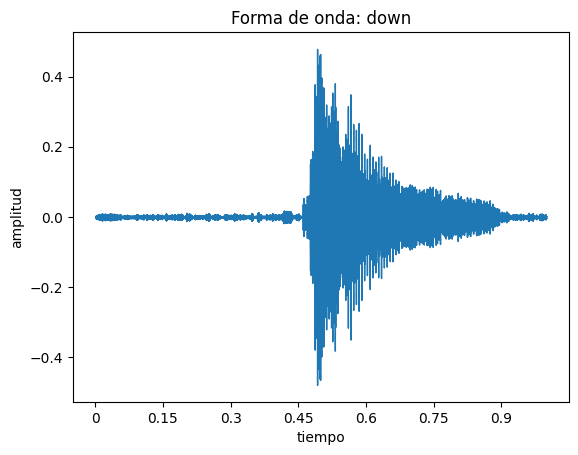

In [ ]:
# inspeccionemos un ejemplo
waveform = x[0].squeeze().numpy()
label = labels[0]

# grafiquemos forma de onda
librosa.display.waveshow(waveform, sr=SAMPLE_RATE)
plt.title(f'Forma de onda: {label}')
plt.xlabel('tiempo')
plt.ylabel('amplitud')
plt.show()

# reproductor
ip.display.Audio(waveform, rate=SAMPLE_RATE)